In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'
os.environ["CUDA_VISIBLE_DEVICES"]=" "

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib
matplotlib.rc("font",family='YouYuan')
%run Inception_Layer.ipynb

In [2]:
filepath=r"C:\Users\Administrator\Desktop\study\Datasets\Kaggle\archive\raw-img"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(filepath, batch_size=18326,image_size = (227, 227), label_mode = "int", validation_split = .3, subset = "training", seed = 27)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(filepath, batch_size=7853,image_size = (227, 227), label_mode = "int", validation_split = .3, subset = "validation", seed = 27)
for train_x,train_y in train_dataset:
    train_x=train_x/255.0
for validation_x,validation_y in validation_dataset:
    validation_x=validation_x/255.0
    
train_dataset_3target=tf.data.Dataset.from_tensor_slices((train_x,(train_y,train_y,train_y)))
validation_dataset_3target = tf.data.Dataset.from_tensor_slices((validation_x,(validation_y,validation_y,validation_y)))
train_dataset_3target=train_dataset_3target.shuffle(buffer_size=20000).batch(200)
validation_dataset_3target=validation_dataset_3target.shuffle(buffer_size=20000).batch(200)

train_dataset_1target=tf.data.Dataset.from_tensor_slices((train_x,train_y))
validation_dataset_1target = tf.data.Dataset.from_tensor_slices((validation_x,validation_y))
train_dataset_1target=train_dataset_1target.shuffle(buffer_size=20000).batch(200)
validation_dataset_1target=validation_dataset_1target.shuffle(buffer_size=20000).batch(200)

Found 26179 files belonging to 10 classes.
Using 18326 files for training.
Found 26179 files belonging to 10 classes.
Using 7853 files for validation.


In [3]:
#Inception v1
inception_3a=Inception([16,24,32,4,8,8])
inception_3b=Inception([32,32,24,8,24,16])
inception_4a=Inception([48,24,24,4,12,16])
inception_4b=Inception([40,24,24,6,16,16])
inception_4c=Inception([32,32,32,6,16,16])
inception_4d=Inception([28,36,32,8,16,16])
inception_4e=Inception([32,40,80,8,32,32])
inception_5a=Inception([32,40,40,8,32,32])
inception_5b=Inception([48,24,48,12,32,32])
regular=tf.keras.regularizers.l2(0.01)

input=keras.Input(shape=(227,227,3))
C1=layers.Conv2D(16,kernel_size=(7,7),strides=2,padding="same",activation="relu")(input)
P2=layers.MaxPool2D(pool_size=3,strides=2,padding="same")(C1)
B3=layers.BatchNormalization()(P2)
C4=layers.Conv2D(16,kernel_size=(1,1),padding="valid",activation="relu")(B3)
C5=layers.Conv2D(48,kernel_size=(3,3),padding="same",activation="relu")(C4)
B6=layers.BatchNormalization()(C5)
P7=layers.MaxPool2D(pool_size=3,strides=2,padding="same")(B6)
I8=inception_3a(P7)
I9=inception_3b(I8)
P10=layers.MaxPool2D(pool_size=3,strides=2,padding="same")(I9)
I11=inception_4a(P10)

S1_P12=layers.AveragePooling2D(pool_size=5,strides=3,padding="valid")(I11)
S1_C13=layers.Conv2D(64,kernel_size=(1,1),activation="relu",padding="same")(S1_P12)
S1_F14=layers.Flatten()(S1_C13)
S1_F15=layers.Dense(64,activation="relu")(S1_F14)
S1_D16=layers.Dropout(0.5)(S1_F15)
S1_F17=layers.Dense(128,activation="relu")(S1_D16)
S1_D18=layers.Dropout(0.5)(S1_F17)
S1_output=layers.Dense(10,activation="softmax",name="S1_output")(S1_D18)

I12=inception_4b(I11)
I13=inception_4c(I12)
I14=inception_4d(I13)

S2_P15=layers.AveragePooling2D(pool_size=5,strides=3,padding="valid")(I14)
S2_C16=layers.Conv2D(64,kernel_size=(1,1),activation="relu",padding="same")(S2_P15)
S2_B17=layers.BatchNormalization()(S2_C16)
S2_F18=layers.Flatten()(S2_B17)
S2_F19=layers.Dense(64,activation="relu")(S2_F18)
S2_D20=layers.Dropout(0.5)(S2_F19)
S2_F21=layers.Dense(128,activation="relu")(S2_D20)
S2_D22=layers.Dropout(0.5)(S2_F21)
S2_output=layers.Dense(10,activation="softmax",name="S2_output")(S2_D22)

I15=inception_4e(I14)
P16=layers.MaxPool2D(pool_size=3,strides=2,padding="same")(I15)
I17=inception_5a(P16)
I18=inception_5b(I17)
P19=layers.AveragePooling2D(pool_size=7,strides=1,padding="valid")(I18)
F20=layers.Flatten()(P19)
F21=layers.Dense(128,activation="relu")(F20)
D22=layers.Dropout(0.5)(F21)
M_output=layers.Dense(10,activation="softmax",name="M_output")(D22)
Inception_v1=keras.Model(inputs=input,outputs=[S1_output,M_output,S2_output])
optimizer = optimizers.Adam(learning_rate=0.001,weight_decay=0.001)
Inception_v1.compile(optimizer=optimizer,
              loss={
                  'M_output':'sparse_categorical_crossentropy',
                  'S1_output':'sparse_categorical_crossentropy',
                  'S2_output':'sparse_categorical_crossentropy'
             },
              loss_weights={
                  'M_output':1.0,
                  'S1_output':0.2,
                  'S2_output':0.3,
             },
              metrics=['accuracy','accuracy','accuracy'],)
model_checkpoint=ModelCheckpoint("inception_v1.keras",save_best_only=True)
early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [18]:
history=Inception_v1.fit(train_dataset_3target,epochs=50,
          validation_data=validation_dataset_3target,
          shuffle=True,callbacks=[model_checkpoint])
train_acc=history.history['accuracy']
vali_acc=history.history['val_accuracy']
plt.plot(train_acc,label="train_acc")
plt.plot(vali_acc,label="val_acc")
plt.legend()
plt.show()

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - M_output_accuracy: 0.2058 - S1_output_accuracy: 0.1866 - S2_output_accuracy: 0.1927 - loss: 8.7166 - val_M_output_accuracy: 0.2451 - val_S1_output_accuracy: 0.1747 - val_S2_output_accuracy: 0.1747 - val_loss: 4.6709
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - M_output_accuracy: 0.3528 - S1_output_accuracy: 0.3153 - S2_output_accuracy: 0.3861 - loss: 3.7906 - val_M_output_accuracy: 0.1747 - val_S1_output_accuracy: 0.1747 - val_S2_output_accuracy: 0.1746 - val_loss: 3.8943
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - M_output_accuracy: 0.4343 - S1_output_accuracy: 0.3906 - S2_output_accuracy: 0.4622 - loss: 2.9114 - val_M_output_accuracy: 0.2458 - val_S1_output_accuracy: 0.2162 - val_S2_output_accuracy: 0.1867 - val_loss: 3.5949
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - M_output_accuracy: 0.4780 - S1_output_accuracy: 0.4245 - S2_output_accuracy: 0.5063 - loss: 2.5832 - val_M_output_accuracy: 0.2227 - val_S1_

Epoch 28/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - M_output_accuracy: 0.8366 - S1_output_accuracy: 0.6047 - S2_output_accuracy: 0.7850 - loss: 1.1544 - val_M_output_accuracy: 0.6915 - val_S1_output_accuracy: 0.5803 - val_S2_output_accuracy: 0.5977 - val_loss: 1.8687
Epoch 29/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - M_output_accuracy: 0.8390 - S1_output_accuracy: 0.6006 - S2_output_accuracy: 0.7805 - loss: 1.1527 - val_M_output_accuracy: 0.7187 - val_S1_output_accuracy: 0.6021 - val_S2_output_accuracy: 0.6962 - val_loss: 1.8096
Epoch 30/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - M_output_accuracy: 0.8512 - S1_output_accuracy: 0.6090 - S2_output_accuracy: 0.7914 - loss: 1.0979 - val_M_output_accuracy: 0.7181 - val_S1_output_accuracy: 0.5917 - val_S2_output_accuracy: 0.7015 - val_loss: 1.6750
Epoch 31/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - M_output_accuracy: 0.8535 - S1_output_accuracy: 0.6037 - S2_output_accuracy: 0.7966 - loss: 1.0917 - val_M_output_accuracy: 0.6330 - val

In [3]:
#Inception v3
regular=tf.keras.regularizers.l2(0.01)
inception_3a=Inception_v3_1([64,48,32,32,64,64,32])
inception_3b=Inception_v3_1([64,64,24,32,72,32,32])
inception_3c=Inception_v3_1([48,48,64,16,32,32,32])
inception_4a=Inception_v3_2([48,24,24,16,12,16,24,16,24,48])
inception_4b=Inception_v3_2([40,24,24,18,16,16,32,24,16,32])
inception_4c=Inception_v3_2([32,32,32,18,16,16,48,24,32,16])
inception_4d=Inception_v3_2([28,36,32,16,16,16,32,32,16,24])
inception_4e=Inception_v3_2([32,40,80,16,64,64,16,32,32,24])
inception_5a=Inception_v3_3([32,40,40,16,32,32,32,16,16])
inception_5b=Inception_v3_3([48,24,48,24,32,32,24,32,32])
input=keras.Input(shape=(227,227,3))
C1=layers.Conv2D(32,kernel_size=(3,3),strides=2,padding="same",activation="relu")(input)
B2=layers.BatchNormalization()(C1)
C3=layers.Conv2D(32,kernel_size=(3,3),padding="same",activation="relu")(B2)
B4=layers.BatchNormalization()(C3)
C5=layers.Conv2D(32,kernel_size=(3,3),padding="valid",activation="relu")(B4)
B6=layers.BatchNormalization()(C5)
P7=layers.MaxPool2D(pool_size=3,strides=2)(B6)
C8=layers.Conv2D(32,kernel_size=(3,3),padding="same",activation="relu")(P7)
C9=layers.Conv2D(32,kernel_size=(3,3),strides=2,padding="same",activation="relu")(C8)
C10=layers.Conv2D(32,kernel_size=(3,3),strides=2,padding="same",activation="relu")(C9)
B11=layers.BatchNormalization()(C10)
I12=inception_3a(B11)
I13=inception_3b(I12)
I14=inception_3c(I13)
I15=inception_4a(I14)
I16=inception_4b(I15)
I17=inception_4c(I16)
I18=inception_4d(I17)
I19=inception_4e(I18)
I20=inception_5a(I19)
I21=inception_5b(I20)
B22=layers.BatchNormalization()(I21)
P23=layers.MaxPool2D(pool_size=8)(B22)
F24=layers.Flatten()(P23)
D25=layers.Dense(256,activation="relu")(F24)
D25=layers.Dropout(0.5)(D25)
output=layers.Dense(10,activation="softmax")(D25)
Inception_v3=keras.Model(inputs=input,outputs=output)
optimizer = optimizers.Adam(learning_rate=0.001,weight_decay=0.001)
Inception_v3.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_checkpoint=ModelCheckpoint("inception_v3.keras",save_best_only=True)

In [ ]:
history=Inception_v3.fit(train_dataset_1target,epochs=50,
          validation_data=validation_dataset_1target,
          shuffle=True,callbacks=[model_checkpoint])
train_acc=history.history['accuracy']
vali_acc=history.history['val_accuracy']
plt.plot(train_acc,label="train_acc")
plt.plot(vali_acc,label="val_acc")
plt.legend()
plt.show()

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 509s 4s/step - accuracy: 0.2400 - loss: 2.2037 - val_accuracy: 0.1747 - val_loss: 2.2688
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 449s 4s/step - accuracy: 0.4102 - loss: 1.7111 - val_accuracy: 0.1747 - val_loss: 2.3875
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.4916 - loss: 1.4811 - val_accuracy: 0.1747 - val_loss: 2.5742
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 456s 4s/step - accuracy: 0.5440 - loss: 1.3132 - val_accuracy: 0.1811 - val_loss: 3.0826
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 461s 4s/step - accuracy: 0.5893 - loss: 1.2098 - val_accuracy: 0.3827 - val_loss: 1.8673
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 484s 4s/step - accuracy: 0.6214 - loss: 1.0960 - val_accuracy: 0.4169 - val_loss: 1.7360
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 479s 4s/step - accuracy: 0.6387 - loss: 1.0534 - val_accuracy: 0.4909 - val_loss: 1.5691
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 478s 4s/step - accuracy: 0.6637 - loss: 0.9740 - val_accuracy: 0.5856 - v

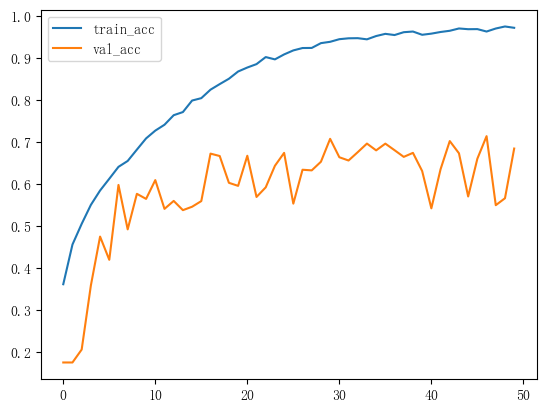

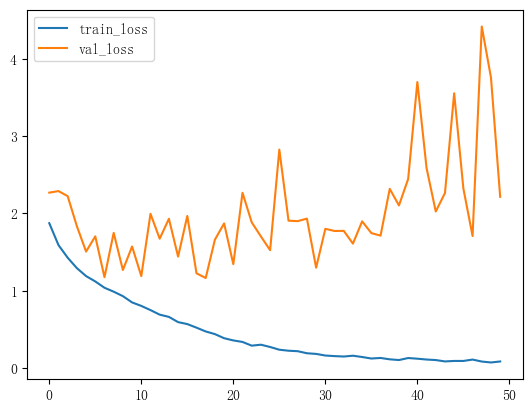

In [22]:
train_acc=history.history['accuracy']
vali_acc=history.history['val_accuracy']
train_loss=history.history['loss']
vali_loss=history.history['val_loss']
plt.plot(train_acc,label="train_acc")
plt.plot(vali_acc,label="val_acc")
plt.legend()
plt.show()
plt.plot(train_loss,label="train_loss")
plt.plot(vali_loss,label="val_loss")
plt.legend()
plt.show()